* [x] ignore illegal action
* [x] penalize revisiting states
* [x] penalize too many steps
* [x] net use cov, output depends on input
* [x] EVALUATION MATRIX BOARD SIZE, VALUE INSIDE IS ACCUARCY!!

* **Deep Q-Learning**
    * [x] [DQN](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
    * [x] [Double DQN](https://arxiv.org/abs/1509.06461)
    * [x] [PER](https://arxiv.org/abs/1511.05952)
* **Policy Gradients**
    * [ ] [A3C/A2C](https://arxiv.org/abs/1602.01783)
    * [ ] [PPO](https://arxiv.org/abs/1707.06347)
    * [ ] [SAC](https://arxiv.org/abs/1801.01290)
* **Deterministic Policy Gradients**
    * [ ] [DPG](http://proceedings.mlr.press/v32/silver14.pdf)
    * [ ] [DDPG](https://arxiv.org/abs/1509.02971)

* loss? measure performance? optimal path? 
* train with sizes X, test on sizes Y
------------------------------
* https://github.com/Taospirit/DRL-with-pytorch
* https://lilianweng.github.io/posts/2018-02-19-rl-overview
* https://spinningup.openai.com/en/latest/spinningup/keypapers.html

* https://boring-guy.sh/posts/masking-rl/
* https://datascience.stackexchange.com/questions/61536/deep-reinforcement-learning-on-changing-data-sizes
* https://stats.stackexchange.com/questions/270618/why-does-q-learning-use-epsilon-greedy-during-testing
* https://daiwk.github.io/assets/dqn.pdf target + experience replay
------------------------------

* loss is much more well-behaved after embedding!
* how to find optimal steps?
* reward enjineering is very important!!!

before implementing the others, I want to make sure the current code for DQN and REINFORCE are accurate enough :(

reformat the code + implement the other papers!

In [ ]:
import random
import copy
import enum
from collections import deque
from typing import List, Tuple
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.model_selection import train_test_split
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import gym
from gym import spaces

from data import data as og_data

In [ ]:
class Phase(enum.Enum):
    TRAINING = TRAIN = enum.auto()
    VALIDATION = VALID = VAL = enum.auto()
    TESTING = TEST = enum.auto()

In [ ]:
class Board:
    def __init__(self, num_color: int, max_length: int, empty: int = 2):
        self.num_color = num_color
        self.max_length = max_length
        self.empty = empty
        self.tubes = self.num_color + self.empty
        self.flasks = np.full((self.tubes, self.max_length), -1, dtype=np.int16)

        self.idx = np.zeros(self.tubes, dtype=np.uint16)
        self.idx[:self.num_color] = self.max_length

        self.actions = []
        self.states = set()

    def __str__(self):
        return str(self.flasks) # [np.argsort(self.flasks[:, 0])])

    def __repr__(self):
        return str(self.flasks)

    def __iter__(self):
        return iter(self.flasks)

    def __len__(self):
        return len(self.flasks)

    def __getitem__(self, item):
        return self.flasks[item]

    def grid_to_state(self) -> List[List[int]]:
        state = []
        for r in self:
            state.append([])
            for c in r:
                if c != -1:
                    state[-1].append(c)
        return state

    def state_to_grid(self, state: List[List[int]]):
        self.flasks.fill(-1)
        self.idx.fill(0)
        self.actions = []
        self.states = set()
        for i, r in enumerate(state):
            self.idx[i] = len(r)
            for j, c in enumerate(r):
                self.flasks[i][j] = c

    def is_flask_full(self, i: int) -> bool:
        return self.idx[i] == self.max_length

    def is_flask_empty(self, i: int) -> bool:
        return self.idx[i] == 0

    def has_one_color(self, i: int) -> bool:
        if self.idx[i] == 0:
            return True
        return (self.flasks[i][:self.idx[i]] == self.flasks[i][0]).all()

    def is_flask_solved(self, i: int) -> bool:
        if self.is_flask_empty(i) or (self.is_flask_full(i) and self.has_one_color(i)):
            return True
        return False

    def top(self, i: int) -> int:
        return self.flasks[i][self.idx[i]-1]

    def pop(self, i: int) -> int:
        ball = self.flasks[i][self.idx[i]-1]
        self.flasks[i][self.idx[i] - 1] = -1
        self.idx[i] -= 1
        return ball

    def push(self, i: int, ball: int):
        self.flasks[i][self.idx[i]] = ball
        self.idx[i] += 1

    def is_push_allowed(self, i: int, ball: int) -> bool:
        if self.is_flask_empty(i) or (self.top(i) == ball and not self.is_flask_full(i)):
            return True
        return False

    def is_invalid_init_state(self) -> bool:
        return any(self.is_flask_full(i) and self.has_one_color(i) for i in range(self.tubes))

    def is_solved(self) -> bool:
        return all(self.is_flask_solved(i) for i in range(self.tubes))

    def valid_actions(self) -> List[Tuple[int, int]]:
        actions = []
        for i in range(self.tubes):
            if self.is_flask_solved(i):
                continue
            if self.is_flask_empty(i):
                continue
            top_i = self.top(i)
            for j in range(self.tubes):
                if i != j and self.is_push_allowed(j, top_i):
                    actions.append((i, j))
        return actions

    def play(self, action: Tuple[int, int]):
        self.push(action[1], self.pop(action[0]))
        self.actions.append(action)

    def undo_action(self):
        action = self.actions.pop()
        self.push(action[0], self.pop(action[1]))

    def reward(self) -> int:
        if self.is_solved():
            return (self.max_length * self.num_color)
        if str(self) in self.states:
            return -10
        return sum(int(self.has_one_color(i)) * self.idx[i] for i in range(self.tubes))

    def dfs_solve(self, steps: int = 0, path: List["Board"] = []) -> Tuple[bool, int, List["Board"]]:
        if self.is_solved():
            return True, steps, path
        if steps >= 1000:
            return False, steps, path
        for a in self.valid_actions():
            self.play(a)
            current_state = str(self)
            if current_state in self.states:
                self.undo_action()
                continue
            self.states.add(current_state)
            path.append(copy.deepcopy(self))
            r = self.dfs_solve(steps+1)
            if r[0]:
                return r
            self.undo_action()
        return False, steps, path

In [ ]:
class BallSort(gym.Env):

    metadata = {"render_modes": ["human", "silent", "cli"]}

    cmap = colors.ListedColormap(['#000000', '#e4572e', '#1b998b', '#29335c', '#f3a712', '#669bbc', '#ed217c', '#58355e', '#f39c6b', '#ca907e', '#aeb7b3', '#c0b9dd', '#a8c686'])

    def __init__(self, train_data, validate_data, test_data, max_color, max_length, max_empty):
        super(BallSort, self).__init__()
        self.env_name = 'ball-sort-puzzle'
        # data
        self.data = {
            Phase.TRAINING: train_data,
            Phase.VALIDATION: validate_data,
            Phase.TESTING: test_data
        }
        # max configurations
        self.max_color = max_color
        self.max_length = max_length
        self.max_empty = max_empty
        self.max_tubes = self.max_color + self.max_empty
        # env action and state spaces
        self.action_space = spaces.Box(low=0, high=self.max_tubes - 1, shape=(2,), dtype=int)
        self.observation_space = spaces.Box(low=-1, high=self.max_color-1, shape=(self.max_tubes, self.max_length), dtype=int)

    def reset(self, phase, i=None):
        super().reset()
        self.steps = 0
        self.reward = 0
        self.solved = False

        # C, L, E, board, steps
        if i is None:
            sample = random.choice(self.data[phase])
        else:
            sample = self.data[phase][i]

        self.color = sample[0]
        self.length = sample[1]
        self.empty = sample[2]
        self.tubes = self.color + self.empty

        self.board = Board(*sample[:3])
        self.board.state_to_grid(sample[3])

        self.render()
        return self.board.flasks, sample[4]

    def step(self, action: Tuple[int, int]):
        # assert action in self.board.valid_actions(), "action must be playable!!"
        if action not in self.board.valid_actions():
            # print("action must be playable!!")
            self.steps += 1
            self.reward = -(self.length * self.color)
            self.solved = False
            self.render()
            return self.board.flasks, self.reward, self.solved, {"steps": self.steps, "done": True}

        self.board.play(action)
        self.steps += 1
        self.reward = self.board.reward()
        self.solved = self.board.is_solved()
        self.board.states.add(str(self.board))
        self.render()

        return self.board.flasks, self.reward, self.solved, {"steps": self.steps, "done": self.solved}

    def render(self):
        if self.render_mode == "cli":
            print("====================================================")
            print("Step:", self.steps)
            print(self.board.grid_to_state())
            print("State Reward:", self.reward)
            print("Is solved:", self.solved)
            print("====================================================")
        elif self.render_mode == "human":
            # plt.figure(figsize=(self.tubes, self.max_length))
            plt.imshow(self.board.flasks.T[::-1], cmap=self.cmap)
            plt.title(f"Step: {self.steps}. Reward: {self.reward}. Solved: {self.solved}")
            plt.axis("off")
            plt.show()

In [ ]:
class Model(nn.Module):
    def __init__(self, max_color, max_length, max_empty, p=0.2, is_prob=False):
        super().__init__()
        self.max_tubes = max_color + max_empty
        self.max_length = max_length
        self.max_color = max_color
        self.max_empty = max_empty

        # max 12 balls + 1 for empty + 1 for padding
        self.em = nn.Embedding(num_embeddings=max_color+2, embedding_dim=3, padding_idx=0)

        self.cnn = [nn.Conv2d(3, 8, (3, 1)), nn.Conv2d(8, 16, (3, 1))]
        self.bn = [nn.BatchNorm2d(8), nn.BatchNorm2d(16)]
        self.drop = nn.Dropout(p=p)
        self.mp = nn.MaxPool2d(2)
        self.flat = nn.Flatten()

        self.fc = [nn.Linear(32, 64), nn.Linear(64, 128), nn.Linear(128, 256), nn.Linear(256, 256)]
        self.out = nn.Linear(256, (self.max_tubes) ** 2)
        self.is_prob = is_prob

    def forward(self, x, mask=None):
        # print(x.size())
        x = self.em(x)
        # print(x.size())
        x = x.permute(0, 3, 1, 2)
        # print(x.size())

        for i in range(len(self.cnn)):
            x = self.cnn[i](x)
            x = self.bn[i](x)
            x = F.relu(x)
            # print(x.size())
            x = self.mp(x)
            x = self.drop(x)
            # print(x.size())

        x = self.flat(x)
        # print(x.size())
        for i in range(len(self.fc)):
            x = self.fc[i](x)
            x = F.relu(x)
            # print(x.size())
        x = self.out(x)
        # print(x.size())

        if mask is not None:
            x[mask] = -np.inf
        if self.is_prob:
            x = F.softmax(x, dim=1)
        return x

In [30]:
class Agent:
    def __init__(self, env, max_color, max_length, max_empty, device):

        self.device = device
        # env set up
        self.max_color = max_color
        self.max_length = max_length
        self.max_empty = max_empty
        self.max_tubes = self.max_color + self.max_empty
        self.num_actions = self.max_tubes * self.max_tubes
        self.num_states = self.max_tubes * self.max_length

        self.env = env

    def get_mask(self):
        allowed_actions = self.env.board.valid_actions()

        allowed_actions_linear = [i * self.max_tubes + j for i, j in allowed_actions]
        mask = torch.ones(self.num_actions, dtype=bool).to(self.device)
        mask[allowed_actions_linear] = False
        return mask

    def pad_state(self, state):
        num_tubes, length = state.shape
        return F.pad(state + 2, (0, self.max_length-length, 0, self.max_tubes-num_tubes), "constant", 0)

    def choose_action(self, state):
        return

    def learn(self):
        return

    def train(self, episodes=500, max_steps=None, plot=False):
        return

    def save(self, **kwargs):
        return

    def load(self, **kwargs):
        return

    def eval_mode(self):
        return

    def eval_one(self, phase, max_steps=None, i=None, render=False):
        if max_steps is not None:
            loop_range = range(max_steps)
        if render:
            self.env.render_mode = "human"
        state, dfs_steps = self.env.reset(phase, i=i)

        states = []

        self.eval_mode()

        with torch.no_grad():
            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                states.append(copy.deepcopy(state))

                state = self.pad_state(torch.LongTensor(state).to(self.device))
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)

                ep_reward += reward
                state = next_state

                if done:
                    break
            states.append(state)
        self.env.render_mode = "silent"
        return {"states": states, "done": done, "ep_reward": ep_reward, "steps": info["steps"], "dfs_steps": dfs_steps}

    def evaluate(self, phase, episodes=None, max_steps=None):
        if max_steps is not None:
            loop_range = range(max_steps)
        self.eval_mode()

        reward_list = []
        step_list = []
        board_config_wins = {}
        if episodes is None:
            episodes = len(self.env.data[phase])
        for i in tqdm(range(1, episodes+1)):
            state, dfs_steps = self.env.reset(phase, i=i-1)
            state = self.pad_state(torch.LongTensor(state).to(self.device))

            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1

            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))

                ep_reward += reward
                state = next_state
                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    break

            step_list.append(info['steps'])
            reward_list.append(ep_reward)
        return {"reward_list": reward_list, "step_list": step_list, "board_config_wins": board_config_wins}

In [31]:
class RandomAgent(Agent):
    def __init__(self, env, max_color, max_length, max_empty, device):
        super().__init__(env, max_color, max_length, max_empty, device)

    def choose_action(self, state):
        allowed_actions = self.env.board.valid_actions()
        if not allowed_actions:
            return (0, 0)
        return random.choice(allowed_actions)
        # action = random.randint(0, self.num_actions-1)
        # i = action // (self.max_tubes)
        # j = action % (self.max_tubes)
        # action = (i, j)
        # return action

    def train(self, episodes=300, max_steps=None, plot=False):
        if max_steps is not None:
            loop_range = range(max_steps)

        print("Collecting Experience....")
        reward_list = []
        step_list = []
        dfs_step_list = []
        board_config_wins = {}
        train_accuracy = []
        total_wins = 0
        total_games = 0
        for i in (pbar := tqdm(range(1, episodes+1))):
            state, dfs_steps = self.env.reset(Phase.TRAINING)
            state = self.pad_state(torch.LongTensor(state).to(self.device))
            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1
            total_games += 1
            ep_reward = 0
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                if info["done"] != done:
                    break
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))
                state = next_state
                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    total_wins += 1
                    break

            dfs_step_list.append(dfs_steps)
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            train_accuracy.append(round(total_wins/total_games*100, 2))
            pbar.set_postfix_str(f"Game: {i}, {self.env.tubes}X{self.env.length}, {'won' if done else 'lost'}, steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, Win: {train_accuracy[-1]}%")
            if plot and ((i) % 50 == 0 or i == episodes):
                fig, ax = plt.subplots(3)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(step_list, 'g-', label='total_steps')
                ax[1].legend(loc="upper left")
                ax[2].plot(train_accuracy, 'g-', label='winning rate')
                ax[2].legend(loc="upper left")
                plt.show()

        return {"reward_list": reward_list, "step_list": step_list, "dfs_step_list": dfs_step_list, "board_config_wins": board_config_wins}

In [78]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = state.view(-1).cpu().numpy()
        next_state = next_state.view(-1).cpu().numpy()
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)


class DDQNAgent(Agent):
    def __init__(self, env, max_color, max_length, max_empty, device, epsilon_start, epsilon_final, epsilon_decay, gamma, lr, batch_size, memory_capacity, q_network_iteration):
        super().__init__(env, max_color, max_length, max_empty, device)

        # reinforcement learning
        self.epsilon_start = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay

        self.gamma = gamma

        # buffer replay set up
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.q_network_iteration = q_network_iteration
        self.replay_buffer = ReplayBuffer(self.memory_capacity)
        self.learn_step_counter = 0

        # neural network
        self.eval_net = Model(self.max_color, self.max_length, self.max_empty).to(self.device)
        self.target_net = Model(self.max_color, self.max_length, self.max_empty).to(self.device)
        self.target_net.load_state_dict(self.eval_net.state_dict())

        self.lr = lr
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)

    def eval_mode(self):
        self.epsilon = 0.05
        self.eval_net.eval()

    def save(self, train_metric=None, validation_metric=None, filename=""):
        best_state = {
            'eval_net': self.eval_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        if train_metric is not None:
            best_state['train_metrics'] = train_metric
        if validation_metric is not None:
            best_state['valid_metrics'] = validation_metric
        torch.save(best_state, f'../models/ddqn/model_{filename}.pt')

    def load(self, filename=""):
        best_state = torch.load(f'../models/ddqn/model_{filename}.pt')

        self.eval_net.load_state_dict(best_state["eval_net"])
        self.target_net.load_state_dict(best_state["target_net"])
        self.optimizer.load_state_dict(best_state["optimizer"])
        return best_state.get('train_metrics'), best_state.get('valid_metrics')

    def choose_random_valid_action(self):
        allowed_actions = self.env.board.valid_actions()
        if not allowed_actions:
            return (0, 0)
        return random.choice(allowed_actions)

    def choose_random_action(self):
        action = random.randint(0, self.num_actions-1)
        i = action // (self.max_tubes)
        j = action % (self.max_tubes)
        action = (i, j)
        return action

    def choose_best_valid_action(self, state):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0), mask.unsqueeze(0))
            # action_probs[:, mask] = -np.inf
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.max_tubes)
            j = action % (self.max_tubes)
            action = (i, j)
            return action

    def choose_best_action(self, state):
        with torch.no_grad():
            action_probs = self.eval_net(state.unsqueeze(0))
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.max_tubes)
            j = action % (self.max_tubes)
            action = (i, j)
            return action

    def choose_action(self, state):
        if np.random.randn() < self.epsilon:
            return self.choose_random_valid_action()
        else:
            return self.choose_best_valid_action(state)

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state.view(-1).cpu().numpy(),
                                [action, reward],
                                # mask.view(-1).cpu().numpy(),
                                next_state.reshape(-1)))
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # update the parameters
        if self.learn_step_counter % self.q_network_iteration == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch from memory
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)
        batch_state = torch.LongTensor(state).view(self.batch_size, self.max_tubes, self.max_length).to(self.device)
        batch_action = torch.LongTensor(action).view(self.batch_size, 1).to(self.device)
        batch_reward = torch.FloatTensor(reward).view(self.batch_size, 1).to(self.device)
        batch_next_state = torch.LongTensor(next_state).view(self.batch_size, self.max_tubes, self.max_length).to(self.device)
        batch_done = torch.FloatTensor(done).view(self.batch_size, 1).to(self.device)

        # method 1
        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach().max(1)[0].view(self.batch_size, 1)
        q_target = batch_reward + self.gamma * q_next * (1-batch_done)
        loss = (q_eval - q_target).pow(2).mean()


        # method 2
#         q_values = self.eval_net(batch_state)
#         next_q_values = self.eval_net(batch_next_state)
#         next_q_state_values = self.target_net(batch_next_state)

#         q_value = q_values.gather(1, batch_action)
#         next_q_value = next_q_state_values.detach().gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1))
#         expected_q_value = batch_reward + self.gamma * next_q_value * (1 - batch_done)
#         loss = (q_value - expected_q_value).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, episodes=300, max_steps=None, plot=None):
        if max_steps is not None:
            loop_range = range(max_steps)
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        dfs_step_list = []
        diff_steps_list = []
        board_config_wins = {}
        train_accuracy = []
        # episodes = len(self.env.train_data)
        total_wins = 0
        total_games = 0
        for i in (pbar := tqdm(range(1, episodes+1))):
            self.epsilon = self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * (i-1) / self.epsilon_decay)
            state, dfs_steps = self.env.reset(Phase.TRAINING)
            state = self.pad_state(torch.LongTensor(state).to(self.device))
            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1
            total_games += 1
            ep_reward = 0
            loss = []
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                if info["done"] != done:
                    print("deadend")
                    break
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))
                self.replay_buffer.push(state, action[0] * self.max_tubes + action[1], reward, next_state, done)

                if len(self.replay_buffer) > self.batch_size:
                    loss.append(self.learn())
                state = next_state

                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    total_wins += 1
                    break
            reward_list.append(ep_reward)
            if len(loss) > 1:
                loss_list.append(np.mean(loss))
            if info["done"] == done:
                dfs_step_list.append(dfs_steps)
                step_list.append(info['steps'])
                diff_steps_list.append(info['steps']/dfs_steps)

            train_accuracy.append(round(total_wins/total_games*100, 2))
            pbar.set_postfix_str(f"Game: {i}, {self.env.tubes}X{self.env.length}, {'won' if done else 'lost'}, steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {np.mean(loss) if loss else ''}, Win: {train_accuracy[-1]}%")
            if (plot and (i) % plot == 0) or i == episodes:
                fig, ax = plt.subplots(5, figsize=(8, 10))
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(dfs_step_list, 'r-', label='dfs_steps')
                ax[2].plot(step_list, 'g-', label='steps')
                ax[2].legend(loc="upper left")
                ax[3].plot(diff_steps_list, 'g-', label='diff_steps_list')
                ax[3].legend(loc="upper left")
                ax[4].plot(train_accuracy, 'g-', label='winning rate')
                ax[4].legend(loc="upper left")
                plt.show()

        return {"reward_list": reward_list, "step_list": step_list, "dfs_step_list": dfs_step_list, "loss_list": loss_list, "board_config_wins": board_config_wins}

In [10]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        state = state.view(-1).cpu().numpy()
        next_state = next_state.view(-1).cpu().numpy()

        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.prob_alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        batch = list(zip(*samples))
        states = np.concatenate(batch[0])
        actions = batch[1]
        rewards = batch[2]
        next_states = np.concatenate(batch[3])
        dones = batch[4]

        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)


class PRDDQNAgent(Agent):
    def __init__(self, env, max_color, max_length, max_empty, device, epsilon_start, epsilon_final, epsilon_decay, beta_start, beta_frames, gamma, lr, batch_size, memory_capacity, q_network_iteration):
        super().__init__(env, max_color, max_length, max_empty, device)

        # reinforcement learning
        self.epsilon_start = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay

        self.beta_start = beta_start
        self.beta_frames = beta_frames

        self.gamma = gamma

        # buffer replay set up
        self.batch_size = batch_size
        self.memory_capacity = memory_capacity
        self.q_network_iteration = q_network_iteration
        self.replay_buffer = NaivePrioritizedBuffer(self.memory_capacity)
        self.learn_step_counter = 0

        # neural network
        self.eval_net = Model(self.max_color, self.max_length, self.max_empty).to(self.device)
        self.target_net = Model(self.max_color, self.max_length, self.max_empty).to(self.device)
        self.target_net.load_state_dict(self.eval_net.state_dict())

        self.lr = lr
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)

    def eval_mode(self):
        self.epsilon = 0.05
        self.eval_net.eval()

    def save(self, train_metric=None, validation_metric=None, filename=""):
        best_state = {
            'eval_net': self.eval_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        if train_metric is not None:
            best_state['train_metrics'] = train_metric
        if validation_metric is not None:
            best_state['valid_metrics'] = validation_metric
        torch.save(best_state, f'../models/prddqn/model_{filename}.pt')

    def load(self, filename=""):
        best_state = torch.load(f'../models/prddqn/model_{filename}.pt')

        self.eval_net.load_state_dict(best_state["eval_net"])
        self.target_net.load_state_dict(best_state["target_net"])
        self.optimizer.load_state_dict(best_state["optimizer"])
        return best_state.get('train_metrics'), best_state.get('valid_metrics')

    def choose_random_valid_action(self):
        allowed_actions = self.env.board.valid_actions()
        if not allowed_actions:
            return (0, 0)
        return random.choice(allowed_actions)

    def choose_random_action(self):
        action = random.randint(0, self.num_actions-1)
        i = action // (self.max_tubes)
        j = action % (self.max_tubes)
        action = (i, j)
        return action

    def choose_best_valid_action(self, state):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0), mask.unsqueeze(0))
            # action_probs[:, mask] = -np.inf
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.max_tubes)
            j = action % (self.max_tubes)
            action = (i, j)
            return action

    def choose_best_action(self, state):
        with torch.no_grad():
            action_probs = self.eval_net(state.unsqueeze(0))
            action_linear = torch.argmax(action_probs, 1)
            action = action_linear.item()
            i = action // (self.max_tubes)
            j = action % (self.max_tubes)
            action = (i, j)
            return action

    def choose_action(self, state):
        if np.random.randn() < self.epsilon:
            return self.choose_random_valid_action()
        else:
            return self.choose_best_valid_action(state)

    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state.view(-1).cpu().numpy(),
                                [action, reward],
                                # mask.view(-1).cpu().numpy(),
                                next_state.reshape(-1)))
        index = self.memory_counter % self.memory_capacity
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # update the parameters
        if self.learn_step_counter % self.q_network_iteration == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch from memory
        state, action, reward, next_state, done, indices, weights = self.replay_buffer.sample(self.batch_size, self.beta)
        batch_state = torch.LongTensor(state).view(self.batch_size, self.max_tubes, self.max_length).to(self.device)
        batch_action = torch.LongTensor(action).view(self.batch_size, 1).to(self.device)
        batch_reward = torch.FloatTensor(reward).view(self.batch_size, 1).to(self.device)
        batch_next_state = torch.LongTensor(next_state).view(self.batch_size, self.max_tubes, self.max_length).to(self.device)
        batch_done = torch.FloatTensor(done).view(self.batch_size, 1).to(self.device)
        batch_weights = torch.FloatTensor(weights).view(self.batch_size, 1).to(self.device)

        # method 1
        q_values = self.eval_net(batch_state)
        next_q_values = self.target_net(batch_next_state)

        q_value = q_values.gather(1, batch_action)
        next_q_value = next_q_values.detach().max(1)[0].view(self.batch_size, 1)
        expected_q_value = batch_reward + self.gamma * next_q_value * (1-batch_done)
        loss = (q_value - expected_q_value).pow(2) * batch_weights
        prios = loss + 1e-5
        loss = loss.mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.replay_buffer.update_priorities(indices, prios.detach().cpu().numpy())
        self.optimizer.step()

        return loss.item()

    def train(self, episodes=300, max_steps=None, plot=None):
        if max_steps is not None:
            loop_range = range(max_steps)
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        dfs_step_list = []
        diff_steps_list = []
        board_config_wins = {}
        train_accuracy = []
        # episodes = len(self.env.train_data)
        total_wins = 0
        total_games = 0
        for i in (pbar := tqdm(range(1, episodes+1))):
            self.epsilon = self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * (i-1) / self.epsilon_decay)
            state, dfs_steps = self.env.reset(Phase.TRAINING)
            state = self.pad_state(torch.LongTensor(state).to(self.device))
            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1
            total_games += 1
            ep_reward = 0
            loss = []
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                ep_reward += reward
                if info["done"] != done:
                    print("deadend")
                    break
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))
                self.replay_buffer.push(state, action[0] * self.max_tubes + action[1], reward, next_state, done)

                if len(self.replay_buffer) > self.batch_size:
                    self.beta = min(1.0, self.beta_start + (i-1) * (1.0 - self.beta_start) / self.beta_frames)
                    loss.append(self.learn())
                state = next_state

                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    total_wins += 1
                    break

            dfs_step_list.append(dfs_steps)
            step_list.append(info['steps'])
            diff_steps_list.append(info['steps']/dfs_steps)
            reward_list.append(ep_reward)
            if len(loss) > 1:
                loss_list.append(np.mean(loss))
            train_accuracy.append(round(total_wins/total_games*100, 2))
            pbar.set_postfix_str(f"Game: {i}, {self.env.tubes}X{self.env.length}, {'won' if done else 'lost'}, steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {np.mean(loss) if loss else ''}, Win: {train_accuracy[-1]}%")
            if (plot and (i) % plot == 0) or i == episodes:
                fig, ax = plt.subplots(5, figsize=(8, 10))
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(dfs_step_list, 'r-', label='dfs_steps')
                ax[2].plot(step_list, 'g-', label='steps')
                ax[2].legend(loc="upper left")
                ax[3].plot(diff_steps_list, 'g-', label='diff_steps_list')
                ax[3].legend(loc="upper left")
                ax[4].plot(train_accuracy, 'g-', label='winning rate')
                ax[4].legend(loc="upper left")
                plt.show()

        return {"reward_list": reward_list, "step_list": step_list, "dfs_step_list": dfs_step_list, "loss_list": loss_list, "board_config_wins": board_config_wins}

In [105]:
class REINFORCEAgent(Agent):
    def __init__(self, env, max_color, max_length, max_empty, epsilon, gamma, lr, device):
        super().__init__(env, max_color, max_length, max_empty, epsilon, gamma, lr, device)

        # memory
        self.saved_log_probs = []
        self.rewards = []

        # neural network
        self.eval_net = Model(self.max_color, self.max_length, self.max_empty, is_prob=True).to(self.device)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=self.lr)

    def save(self, train_metric=None, validation_metric=None, filename=""):
        best_state = {
            'eval_net': self.eval_net.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        if train_metric is not None:
            best_state['train_metrics'] = dqn_train_res["board_config_wins"]
        if validation_metric is not None:
            best_state['valid_metrics'] = dqn_val_res["board_config_wins"]
        torch.save(best_state, f'../models/reinforce/model_{filename}.pt')

    def load(self, filename=""):
        best_state = torch.load(f'../models/reinforce/model_{filename}.pt')

        self.eval_net.load_state_dict(best_state["eval_net"])
        self.optimizer.load_state_dict(best_state["optimizer"])
        return best_state.get('train_metrics'), best_state.get('valid_metrics')

    def choose_action(self, state, phase=Phase.TRAINING):
        with torch.no_grad():
            mask = self.get_mask()
            action_probs = self.eval_net(state.unsqueeze(0), mask.unsqueeze(0))
            try:
                m = Categorical(action_probs)
                action = m.sample()
                if phase == Phase.TRAINING:
                    self.saved_log_probs.append(m.log_prob(action))
                action = action.item()
                i = action // (self.max_tubes)
                j = action % (self.max_tubes)
                action = (i, j)
                return action
            except ValueError:
                return (0, 0)

    def learn(self):
        R = 0
        policy_loss = []
        rewards = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards, requires_grad=True)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.epsilon)
        for log_prob, reward in zip(self.saved_log_probs, rewards):
            policy_loss.append(-log_prob * reward)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        self.saved_log_probs = []
        self.rewards = []

        return policy_loss.item()

    def train(self, episodes=300, max_steps=None, plot=False):
        if max_steps is not None:
            loop_range = range(max_steps)
        self.eval_net.train()
        print("Collecting Experience....")
        reward_list = []
        step_list = []
        loss_list = []
        dfs_step_list = []
        train_accuracy = []
        board_config_wins = {}
        total_wins = 0
        total_games = 0
        for i in (pbar := tqdm(range(1, episodes+1))):
            state, dfs_steps = self.env.reset(Phase.TRAINING)
            state = self.pad_state(torch.LongTensor(state).to(self.device))
            if not board_config_wins.get((self.env.tubes, self.env.length)):
                board_config_wins[(self.env.tubes, self.env.length)] = [1, 0]
            else:
                board_config_wins[(self.env.tubes, self.env.length)][0] += 1
            total_games += 1
            ep_reward = 0
            loss = []
            if max_steps is None:
                loop_range = range(dfs_steps)
            for j in loop_range: # max steps allowed                
                action = self.choose_action(state)
                next_state, reward, done, info = self.env.step(action)
                self.rewards.append(reward)
                ep_reward += reward
                # if info["done"] != done:
                #     break
                next_state = self.pad_state(torch.LongTensor(next_state).to(self.device))
                state = next_state
                if done:
                    board_config_wins[(self.env.tubes, self.env.length)][1] += 1
                    total_wins += 1
                    break
            loss = self.learn()
            loss_list.append(loss)
            dfs_step_list.append(dfs_steps)
            step_list.append(info['steps'])
            reward_list.append(ep_reward)
            train_accuracy.append(round(total_wins/total_games*100, 2))
            pbar.set_postfix_str(f"Game: {i}, {self.env.tubes}X{self.env.length}, {'won' if done else 'lost'}, steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {loss}, Win: {train_accuracy[-1]}%")
            if plot and ((i) % 50 == 0 or i == episodes):
                print(f"Episode: {i}, Steps: {info['steps']}, dfs_steps: {dfs_steps}, reward: {ep_reward}, loss {loss}")
                fig, ax = plt.subplots(4)
                ax[0].plot(reward_list, 'g-', label='total_rewards')
                ax[0].legend(loc="upper left")
                ax[1].plot(loss_list, 'g-', label='total_loss')
                ax[1].legend(loc="upper left")
                ax[2].plot(step_list, 'g-', label='total_steps')
                ax[2].legend(loc="upper left")
                ax[3].plot(train_accuracy, 'g-', label='winning rate')
                ax[3].legend(loc="upper left")
                plt.show()

        return {"reward_list": reward_list, "step_list": step_list, "dfs_step_list": dfs_step_list, "loss_list": loss_list, "board_config_wins": board_config_wins}

In [11]:
def plot_data_dist(data):
    count_by_tube = {}
    count_by_length = {}
    count_by_config = {}
    for sample in data:
        count_by_tube[sample[0]+2] = count_by_tube.get(sample[0]+2, 0) + 1
        count_by_length[sample[1]] = count_by_length.get(sample[1], 0) + 1
        count_by_config[(sample[0]+2, sample[1])] = count_by_config.get((sample[0]+2, sample[1]), 0) + 1

    count_by_tube = sorted(count_by_tube.items(), key=lambda x: x[0])
    count_by_length = sorted(count_by_length.items(), key=lambda x: x[0])
    count_by_config = sorted(count_by_config.items(), key=lambda x: x[0])

    plt.figure(figsize=(25, 5))
    plt.subplot(1, 2, 1)
    r = np.arange(len(count_by_tube))
    plt.bar(r, [x[1] for x in count_by_tube])
    plt.xticks(r, [x[0] for x in count_by_tube])
    plt.title("Count per number of tubes")
    plt.subplot(1, 2, 2)
    r = np.arange(len(count_by_length))
    plt.bar(r, [x[1] for x in count_by_length])
    plt.xticks(r, [x[0] for x in count_by_length])
    plt.title("Count per number of balls")
    plt.show()
    plt.figure(figsize=(25, 5))
    r = np.arange(len(count_by_config))
    plt.bar(r, [x[1] for x in count_by_config])
    plt.xticks(r, [x[0] for x in count_by_config], rotation = 45)
    plt.title("Count per board config")
    plt.show()

In [12]:
def print_eval_num(board_config_wins):
    total_wins = 0
    total_games = 0
    win_by_color = {}
    total_by_color = {}
    win_by_length = {}
    total_by_length = {}
    for k, v in board_config_wins.items():
        total_wins += v[1]
        total_games += v[0]
        win_by_color[k[0]] = win_by_color.get(k[0], 0) + v[1]
        total_by_color[k[0]] = total_by_color.get(k[0], 0) + v[0]
        win_by_length[k[1]] = win_by_length.get(k[1], 0) + v[1]
        total_by_length[k[1]] = total_by_length.get(k[1], 0) + v[0]
    print(total_wins, total_games, win_by_color, total_by_color, win_by_length, total_by_length)
    print(f"Win: {round(total_wins/total_games*100, 2)}% ({total_games} games)")
    print("Win by number of Tubes (2 empty)")
    for k in win_by_color:
        print(f"\t{k}: {round(win_by_color[k]/total_by_color[k]*100, 2)}% ({total_by_color[k]} games)")
    print("Win by Length")
    for k in win_by_length:
        print(f"\t{k}: {round(win_by_length[k]/total_by_length[k]*100, 2)}% ({total_by_length[k]} games)")

In [13]:
def plot_winning(board_configs):
    labels = []
    by_label = []

    by_all_x = []
    by_all_y = []
    by_color_x = []
    by_color_y = []
    by_length_x = []
    by_length_y = []

    by_all_x = sorted((list(board_configs.values())[0]).keys())
    by_all_x = sorted((list(board_configs.values())[0]).keys())

    by_color_x = sorted(set([x[0] for x in by_all_x]))
    by_length_x = sorted(set([x[1] for x in by_all_x]))

    for label, board_config_wins in board_configs.items():
        labels.append(label)
        total_wins = 0
        total_games = 0
        win_by_color = {}
        total_by_color = {}
        win_by_length = {}
        total_by_length = {}
        by_all = []
        for k in by_all_x:
            v = board_config_wins[k]
            total_wins += v[1]
            total_games += v[0]
            by_all.append(round(v[1]/v[0]*100, 2))
            win_by_color[k[0]] = win_by_color.get(k[0], 0) + v[1]
            total_by_color[k[0]] = total_by_color.get(k[0], 0) + v[0]
            win_by_length[k[1]] = win_by_length.get(k[1], 0) + v[1]
            total_by_length[k[1]] = total_by_length.get(k[1], 0) + v[0]
        by_all_y.append(by_all)
        by_label.append(round(total_wins/total_games*100, 2))
        by_color = []
        for k in by_color_x:
            by_color.append(round(win_by_color[k]/total_by_color[k]*100, 2))
        by_color_y.append(by_color)
        by_length = []
        for k in by_length_x:
            by_length.append(round(win_by_length[k]/total_by_length[k]*100, 2))
        by_length_y.append(by_length)

    plt.figure(figsize=(25, 5))
    plt.subplot(1, 3, 1)
    plt.bar(labels, by_label, edgecolor='black')
    plt.xlabel("Expirement")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate")

    plt.subplot(1, 3, 2)
    n = len(by_color_y[0])
    r = np.arange(n)
    width = .9 / len(labels)

    for i, label in enumerate(labels):
        plt.bar(r + i*width, by_color_y[i], width=width, edgecolor='black', label=label)

    plt.xlabel("Number of tubes (2 empty initially)")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate - grouped by the number of tubes")
    plt.xticks(r + ((width) * (len(labels) - 1)/2), by_color_x)
    plt.legend()

    plt.subplot(1, 3, 3)
    n = len(by_length_y[0])
    r = np.arange(n)
    width = .9 / len(labels)

    for i, label in enumerate(labels):
        plt.bar(r + i*width, by_length_y[i], width=width, edgecolor='black', label=label)

    plt.xlabel("Balls per tube")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate - grouped by the number of balls per tube")
    plt.xticks(r + ((width) * (len(labels) - 1)/2), by_length_x)
    plt.legend()

    plt.show()

    plt.figure(figsize=(25, 5))
    r = np.arange(len(by_all_x))
    width = .9 / len(labels)

    for i, label in enumerate(labels):
        plt.bar(r + i*width, by_all_y[i], width=width, edgecolor='black', label=label)

    plt.xlabel("Tube, Balls")
    plt.ylabel("Percentage of Game Won")
    plt.title("Winning Rate - by board configuration")
    plt.xticks(r + ((width) * (len(labels) - 1)/2), by_all_x, rotation = 45)
    plt.legend()

    plt.show()

In [200]:
def plot_cm_for_a_model(board_config, expirement):
    matrix_total = []
    matrix_win = []

    for c in range(4, 15):
        row_t = []
        row_w = []
        for l in range(2, 7):
            try:
                row_t.append(board_config[(c, l)][0])
            except:
                row_t.append(0)
            try:
                row_w.append(round(100 * board_config[(c, l)][1] / board_config[(c, l)][0], 2))
            except:
                row_w.append(np.nan)
        matrix_total.append(row_t)
        matrix_win.append(row_w)

    matrix = {"Count per board config": matrix_total, f"Win per board config": matrix_win}
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    i = 0
    for k, m in matrix.items():
        sns.heatmap(m, annot=True, fmt='g', ax=ax[i])
        ax[i].set_title(k)
        ax[i].set_xlabel("# of tubes (2 empty)")
        ax[i].set_ylabel("# of balls per tube")
        ax[i].xaxis.set_ticklabels(range(2, 7))
        ax[i].yaxis.set_ticklabels(range(4, 15))
        i += 1
    plt.suptitle(f"Expirement: {expirement}", fontsize=14)

In [144]:
SEED = 100
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# data
print(len(og_data), sum([len(v) for v in og_data.values()]))

data = []
HOW_MANY = 3
for k, v in og_data.items():
    if len(v) < HOW_MANY:
        r = v
    else:
        r = random.choices(v, k=HOW_MANY)
    for el in r:
        data.append((*k, *el))
print(len(data), data[0])

max_color, max_length, max_empty = max(x[0] for x in data), max(x[1] for x in data), max(x[2] for x in data)
print(max_color, max_length, max_empty)

train_data, test_data = train_test_split(data, test_size=0.5, random_state=SEED)
test_data, validate_data = train_test_split(test_data, test_size=0.5, random_state=SEED)
train_data, validate_data, test_data = train_data, validate_data, test_data

print(len(train_data), len(validate_data), len(test_data))

49 16203
129 (2, 2, 2, [[0, 1], [0, 1]], 6)
12 6 2
64 33 32


In [145]:
env = BallSort(train_data, validate_data, test_data, max_color, max_length, max_empty)

In [212]:
# hyper-parameters
batch_size = 32
memory_capacity = 1000
q_network_iteration = 100


epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500


beta_start = 0.4
beta_frames = 1000 

lr = 5e-5
gamma = 0.99
max_steps = 100
device = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
episodes = len(train_data)

 97%|█████████▋| 62/64 [00:36<00:01,  1.41it/s, Game: 64, 13X3, won, steps: 58, dfs_steps: 78, reward: 624, loss 134.40526962280273, Win: 62.5%]     

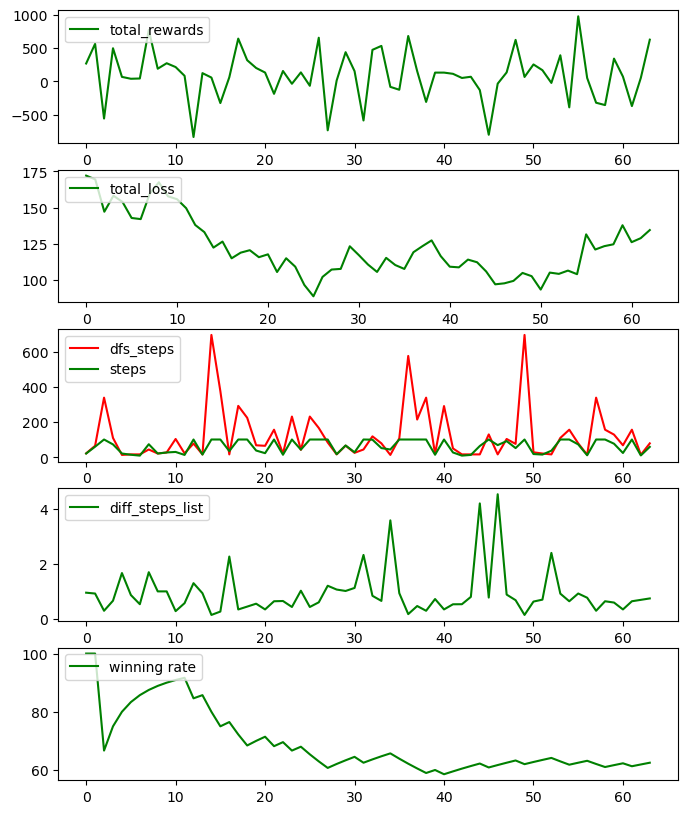

100%|██████████| 64/64 [00:37<00:00,  1.72it/s, Game: 64, 13X3, won, steps: 58, dfs_steps: 78, reward: 624, loss 134.40526962280273, Win: 62.5%]


In [204]:
ddqn = DDQNAgent(env, max_color, max_length, max_empty, device, epsilon_start, epsilon_final, epsilon_decay, gamma, lr, batch_size, memory_capacity, q_network_iteration)
ddqn_train_res = ddqn.train(episodes, max_steps=max_steps, plot=100)

In [205]:
print_eval_num(ddqn_train_res["board_config_wins"])

40 64 {14: 1, 10: 2, 6: 6, 4: 6, 7: 10, 8: 2, 11: 3, 12: 1, 9: 2, 13: 5, 5: 2} {14: 5, 10: 5, 6: 8, 4: 6, 7: 10, 8: 5, 11: 6, 12: 5, 9: 4, 13: 8, 5: 2} {2: 16, 3: 10, 6: 0, 5: 7, 4: 7} {2: 16, 3: 13, 6: 5, 5: 16, 4: 14}
Win: 62.5% (64 games)
Win by number of Tubes (2 empty)
	14: 20.0% (5 games)
	10: 40.0% (5 games)
	6: 75.0% (8 games)
	4: 100.0% (6 games)
	7: 100.0% (10 games)
	8: 40.0% (5 games)
	11: 50.0% (6 games)
	12: 20.0% (5 games)
	9: 50.0% (4 games)
	13: 62.5% (8 games)
	5: 100.0% (2 games)
Win by Length
	2: 100.0% (16 games)
	3: 76.92% (13 games)
	6: 0.0% (5 games)
	5: 43.75% (16 games)
	4: 50.0% (14 games)


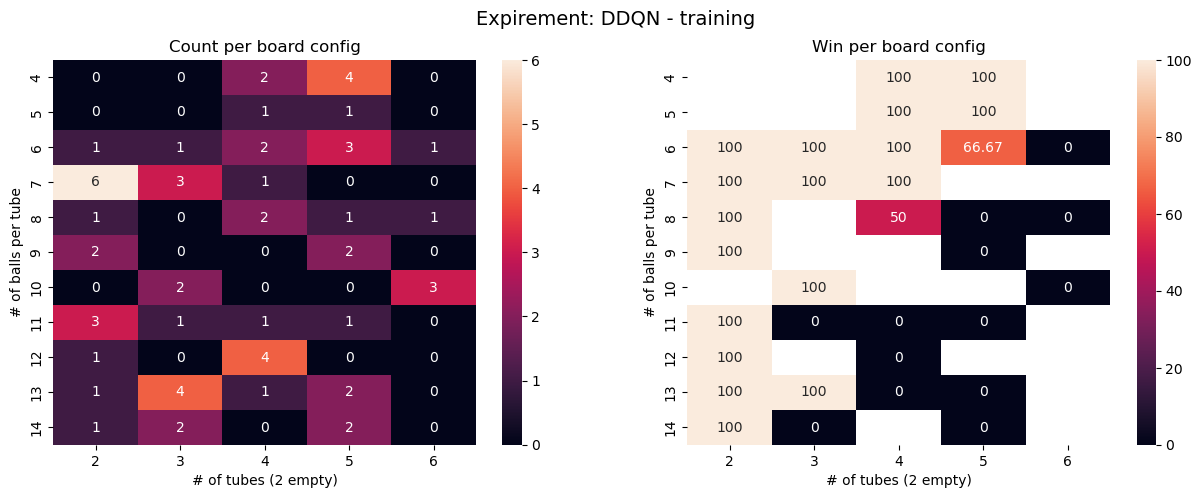

In [206]:
plot_cm_for_a_model(ddqn_train_res["board_config_wins"], "DDQN - training")

In [213]:
ddqn_val_res = ddqn.evaluate(Phase.VALIDATION, max_steps=max_steps)
print_eval_num(ddqn_val_res["board_config_wins"])

100%|██████████| 33/33 [00:03<00:00,  9.21it/s]

19 33 {7: 0, 5: 3, 14: 2, 11: 1, 9: 2, 10: 1, 8: 2, 4: 2, 12: 2, 13: 1, 6: 3} {7: 3, 5: 4, 14: 3, 11: 2, 9: 4, 10: 4, 8: 3, 4: 2, 12: 3, 13: 2, 6: 3} {6: 0, 2: 12, 3: 5, 5: 1, 4: 1} {6: 5, 2: 12, 3: 8, 5: 4, 4: 4}
Win: 57.58% (33 games)
Win by number of Tubes (2 empty)
	7: 0.0% (3 games)
	5: 75.0% (4 games)
	14: 66.67% (3 games)
	11: 50.0% (2 games)
	9: 50.0% (4 games)
	10: 25.0% (4 games)
	8: 66.67% (3 games)
	4: 100.0% (2 games)
	12: 66.67% (3 games)
	13: 50.0% (2 games)
	6: 100.0% (3 games)
Win by Length
	6: 0.0% (5 games)
	2: 100.0% (12 games)
	3: 62.5% (8 games)
	5: 25.0% (4 games)
	4: 25.0% (4 games)


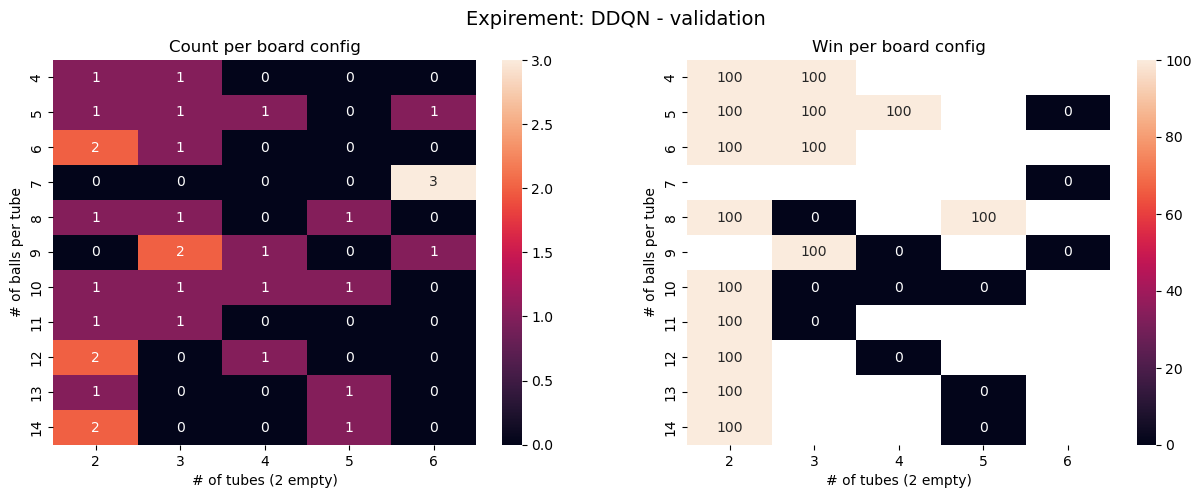

In [214]:
plot_cm_for_a_model(ddqn_val_res["board_config_wins"], "DDQN - validation")

In [215]:
np.mean(ddqn_train_res['step_list']), np.mean(ddqn_val_res['step_list'])

(60.359375, 60.03030303030303)

  1%|          | 2/276 [00:00<00:15, 18.24it/s, Game: 2, 10X4, lost, steps: 24, dfs_steps: 170, reward: -104, loss 231.90913312137127, Win: 50.0%]

deadend


 22%|██▏       | 62/276 [01:16<02:00,  1.77it/s, Game: 62, 10X4, lost, steps: 22, dfs_steps: 100, reward: -101, loss 399.1687520345052, Win: 82.26%]  

deadend


 36%|███▌      | 99/276 [01:43<01:52,  1.57it/s, Game: 100, 8X3, won, steps: 38, dfs_steps: 71, reward: 93, loss 441.29792685257763, Win: 89.0%]    

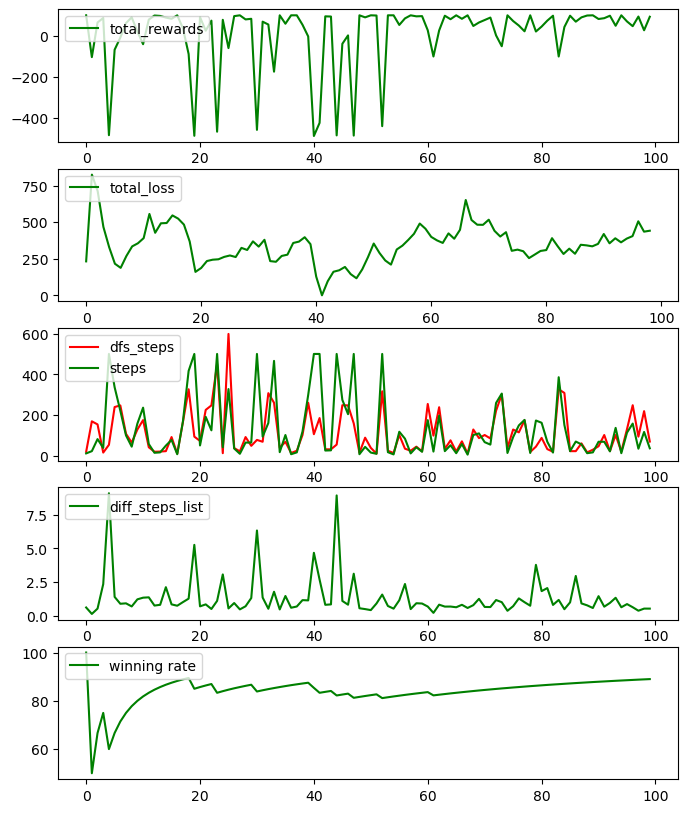

 72%|███████▏  | 199/276 [03:46<00:41,  1.86it/s, Game: 200, 6X3, won, steps: 13, dfs_steps: 33, reward: 100, loss 201.47531186617337, Win: 88.0%]      

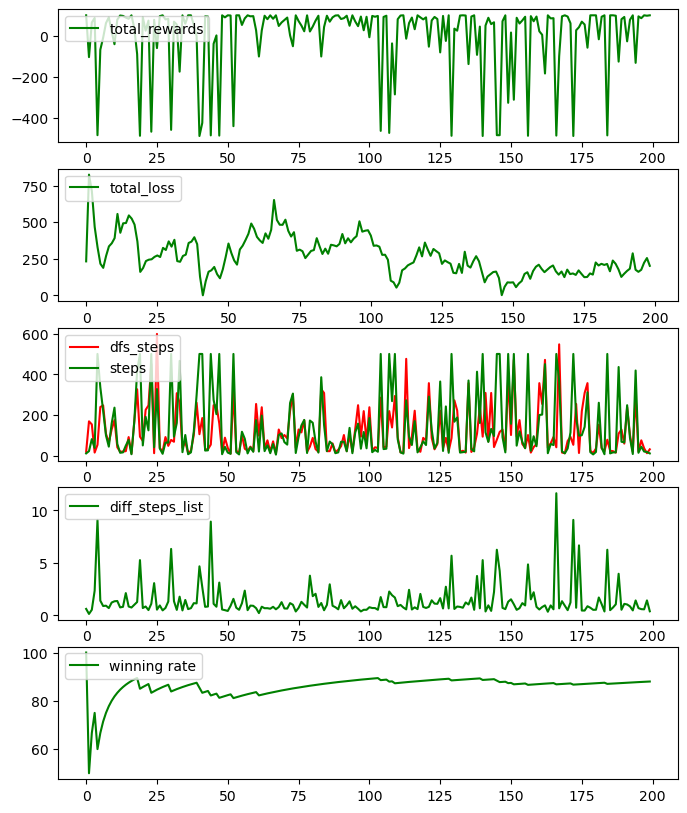

 79%|███████▉  | 218/276 [04:03<00:58,  1.01s/it, Game: 218, 10X4, lost, steps: 24, dfs_steps: 100, reward: -104, loss 101.70911598205566, Win: 87.61%]

deadend


 96%|█████████▌| 264/276 [04:56<00:11,  1.02it/s, Game: 265, 5X2, won, steps: 5, dfs_steps: 9, reward: 100, loss 144.20419921875, Win: 87.55%]          

deadend


100%|█████████▉| 275/276 [05:15<00:02,  2.04s/it, Game: 276, 11X2, won, steps: 16, dfs_steps: 38, reward: 98, loss 62.491588950157166, Win: 87.32%]     

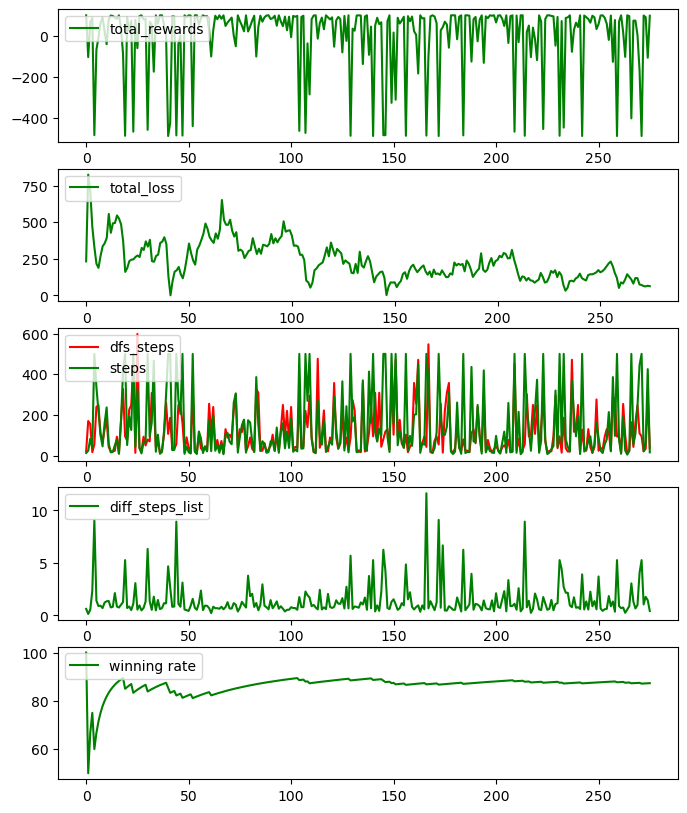

100%|██████████| 276/276 [05:15<00:00,  1.14s/it, Game: 276, 11X2, won, steps: 16, dfs_steps: 38, reward: 98, loss 62.491588950157166, Win: 87.32%]


In [210]:
prddqn = PRDDQNAgent(env, max_color, max_length, max_empty, device, epsilon_start, epsilon_final, epsilon_decay, beta_start, beta_frames, gamma, lr, batch_size, memory_capacity, q_network_iteration)
prddqn_train_res = prddqn.train(episodes, max_steps=500, plot=100)

In [211]:
print_eval_num(prddqn_train_res["board_config_wins"])

241 276 {8: 29, 10: 20, 6: 27, 9: 32, 12: 20, 11: 19, 5: 11, 7: 37, 13: 33, 14: 11, 4: 2} {8: 33, 10: 27, 6: 27, 9: 33, 12: 26, 11: 26, 5: 11, 7: 37, 13: 35, 14: 19, 4: 2} {2: 69, 4: 55, 3: 48, 6: 17, 5: 52} {2: 69, 4: 66, 3: 66, 6: 21, 5: 54}
Win: 87.32% (276 games)
Win by number of Tubes (2 empty)
	8: 87.88% (33 games)
	10: 74.07% (27 games)
	6: 100.0% (27 games)
	9: 96.97% (33 games)
	12: 76.92% (26 games)
	11: 73.08% (26 games)
	5: 100.0% (11 games)
	7: 100.0% (37 games)
	13: 94.29% (35 games)
	14: 57.89% (19 games)
	4: 100.0% (2 games)
Win by Length
	2: 100.0% (69 games)
	4: 83.33% (66 games)
	3: 72.73% (66 games)
	6: 80.95% (21 games)
	5: 96.3% (54 games)


In [212]:
prddqn_val_res = prddqn.evaluate(Phase.VALIDATION, max_steps=500)
print_eval_num(prddqn_val_res["board_config_wins"])

100%|██████████| 138/138 [00:39<00:00,  3.53it/s]

103 138 {6: 11, 10: 10, 12: 10, 9: 17, 7: 14, 5: 4, 14: 4, 13: 14, 8: 8, 11: 9, 4: 2} {6: 11, 10: 25, 12: 15, 9: 18, 7: 15, 5: 4, 14: 8, 13: 14, 8: 13, 11: 13, 4: 2} {6: 4, 5: 19, 3: 24, 4: 19, 2: 37} {6: 13, 5: 28, 3: 31, 4: 29, 2: 37}
Win: 74.64% (138 games)
Win by number of Tubes (2 empty)
	6: 100.0% (11 games)
	10: 40.0% (25 games)
	12: 66.67% (15 games)
	9: 94.44% (18 games)
	7: 93.33% (15 games)
	5: 100.0% (4 games)
	14: 50.0% (8 games)
	13: 100.0% (14 games)
	8: 61.54% (13 games)
	11: 69.23% (13 games)
	4: 100.0% (2 games)
Win by Length
	6: 30.77% (13 games)
	5: 67.86% (28 games)
	3: 77.42% (31 games)
	4: 65.52% (29 games)
	2: 100.0% (37 games)


In [213]:
np.mean(prddqn_train_res['step_list']), np.mean(prddqn_val_res['step_list'])

(148.07608695652175, 205.3840579710145)

In [64]:
# dqn.save(dqn_train_res["board_config_wins"], dqn_val_res["board_config_wins"], f"smart reward 10, {EPISODES} episodes, MLP, no max")

 17%|█▋        | 48/276 [00:10<00:26,  8.75it/s, Game: 50, 8X4, lost, steps: 500, dfs_steps: 40, reward: -456, Win: 80.0%]   

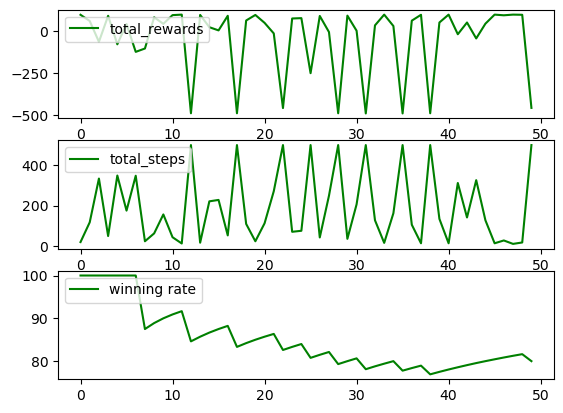

 36%|███▌      | 99/276 [00:20<00:29,  6.08it/s, Game: 100, 13X2, won, steps: 20, dfs_steps: 22, reward: 97, Win: 82.0%]     

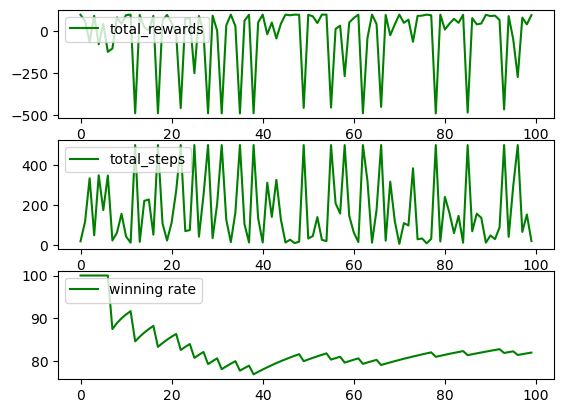

 54%|█████▍    | 149/276 [00:28<00:16,  7.57it/s, Game: 150, 8X5, won, steps: 165, dfs_steps: 239, reward: 14, Win: 82.67%]    

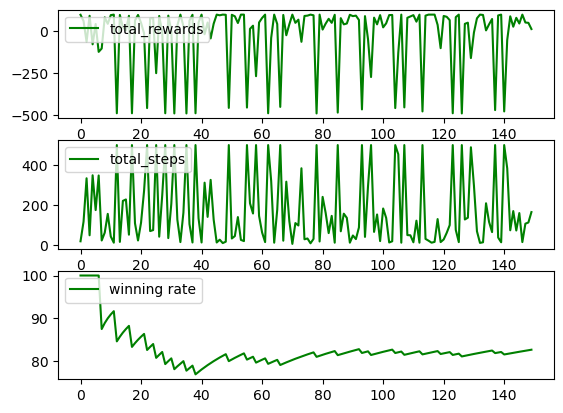

 72%|███████▏  | 198/276 [00:37<00:17,  4.49it/s, Game: 200, 9X3, won, steps: 34, dfs_steps: 40, reward: 96, Win: 85.5%]       

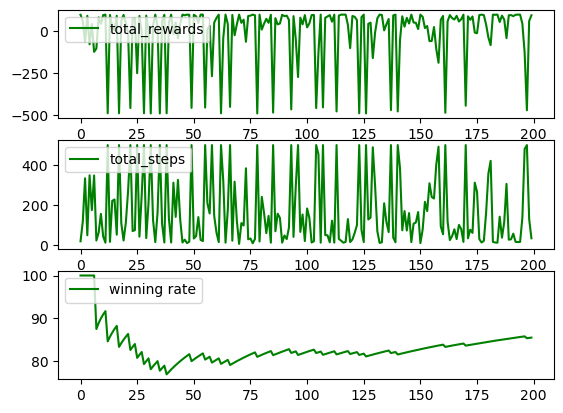

 90%|████████▉ | 248/276 [00:45<00:05,  5.37it/s, Game: 250, 14X2, won, steps: 21, dfs_steps: 38, reward: 100, Win: 87.6%]     

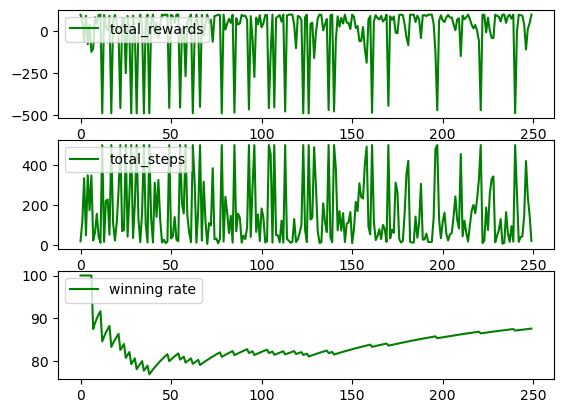

100%|█████████▉| 275/276 [00:48<00:00, 12.80it/s, Game: 276, 12X4, won, steps: 161, dfs_steps: 79, reward: 46, Win: 88.77%]   

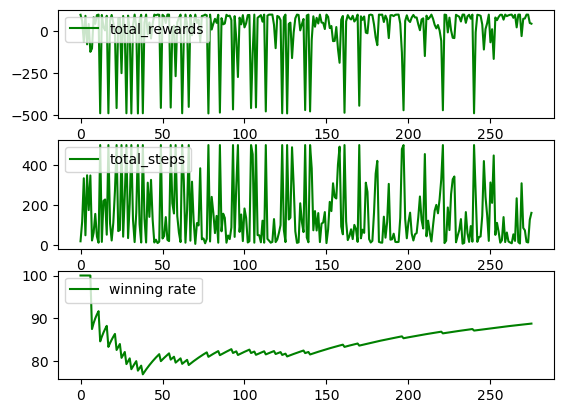

100%|██████████| 276/276 [00:48<00:00,  5.68it/s, Game: 276, 12X4, won, steps: 161, dfs_steps: 79, reward: 46, Win: 88.77%]


In [153]:
rand = RandomAgent(env, max_color, max_length, max_empty, device,)
rand_train_res = rand.train(episodes, max_steps=500, plot=100)

In [154]:
print_eval_num(rand_train_res["board_config_wins"])

245 276 {13: 25, 11: 33, 9: 31, 12: 20, 10: 23, 8: 30, 14: 15, 7: 32, 6: 28, 5: 7, 4: 1} {13: 25, 11: 39, 9: 32, 12: 27, 10: 29, 8: 33, 14: 22, 7: 33, 6: 28, 5: 7, 4: 1} {2: 62, 4: 58, 6: 19, 3: 49, 5: 57} {2: 62, 4: 68, 6: 25, 3: 63, 5: 58}
Win: 88.77% (276 games)
Win by number of Tubes (2 empty)
	13: 100.0% (25 games)
	11: 84.62% (39 games)
	9: 96.88% (32 games)
	12: 74.07% (27 games)
	10: 79.31% (29 games)
	8: 90.91% (33 games)
	14: 68.18% (22 games)
	7: 96.97% (33 games)
	6: 100.0% (28 games)
	5: 100.0% (7 games)
	4: 100.0% (1 games)
Win by Length
	2: 100.0% (62 games)
	4: 85.29% (68 games)
	6: 76.0% (25 games)
	3: 77.78% (63 games)
	5: 98.28% (58 games)


In [158]:
rand_val_res = rand.evaluate(Phase.VALIDATION, max_steps=500)
print_eval_num(rand_val_res["board_config_wins"])

100%|██████████| 138/138 [00:25<00:00,  5.41it/s]

113 138 {6: 10, 10: 14, 12: 10, 9: 18, 7: 15, 5: 4, 14: 5, 13: 14, 8: 10, 11: 11, 4: 2} {6: 11, 10: 25, 12: 15, 9: 18, 7: 15, 5: 4, 14: 8, 13: 14, 8: 13, 11: 13, 4: 2} {6: 6, 5: 28, 3: 23, 4: 19, 2: 37} {6: 13, 5: 28, 3: 31, 4: 29, 2: 37}
Win: 81.88% (138 games)
Win by number of Tubes (2 empty)
	6: 90.91% (11 games)
	10: 56.0% (25 games)
	12: 66.67% (15 games)
	9: 100.0% (18 games)
	7: 100.0% (15 games)
	5: 100.0% (4 games)
	14: 62.5% (8 games)
	13: 100.0% (14 games)
	8: 76.92% (13 games)
	11: 84.62% (13 games)
	4: 100.0% (2 games)
Win by Length
	6: 46.15% (13 games)
	5: 100.0% (28 games)
	3: 74.19% (31 games)
	4: 65.52% (29 games)
	2: 100.0% (37 games)


In [159]:
np.mean(rand_train_res['step_list']), np.mean(rand_val_res['step_list'])

(155.81884057971016, 178.0)

 17%|█▋        | 48/276 [00:11<00:53,  4.22it/s, Game: 50, 6X3, won, steps: 16, dfs_steps: 33, reward: 9, loss 1.039917230606079, Win: 52.0%]          

Episode: 50, Steps: 16, dfs_steps: 33, reward: 9, loss 1.039917230606079


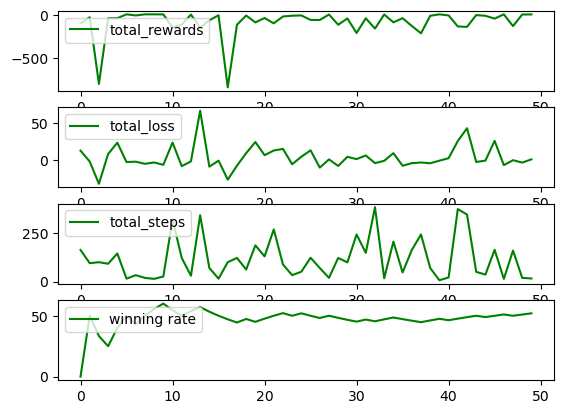

 36%|███▌      | 99/276 [00:19<00:25,  6.84it/s, Game: 100, 9X4, won, steps: 110, dfs_steps: 198, reward: -14, loss 4.676454544067383, Win: 59.0%]    

Episode: 100, Steps: 110, dfs_steps: 198, reward: -14, loss 4.676454544067383


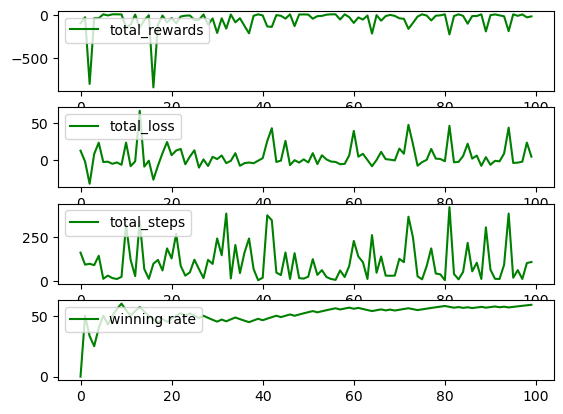

 54%|█████▍    | 149/276 [00:29<00:11, 10.83it/s, Game: 150, 12X2, won, steps: 20, dfs_steps: 37, reward: 9, loss -3.835620403289795, Win: 60.67%]      

Episode: 150, Steps: 20, dfs_steps: 37, reward: 9, loss -3.835620403289795


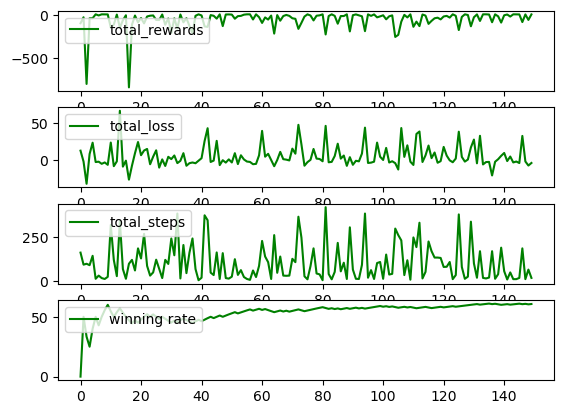

 72%|███████▏  | 199/276 [00:38<00:16,  4.81it/s, Game: 200, 4X5, lost, steps: 15, dfs_steps: 15, reward: -2, loss 1.3027946949005127, Win: 57.0%]        

Episode: 200, Steps: 15, dfs_steps: 15, reward: -2, loss 1.3027946949005127


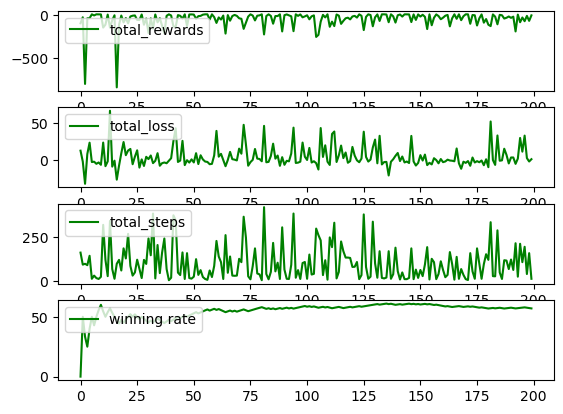

 90%|█████████ | 249/276 [00:45<00:06,  4.47it/s, Game: 250, 6X3, won, steps: 18, dfs_steps: 33, reward: 6, loss 1.8212560415267944, Win: 54.8%]         

Episode: 250, Steps: 18, dfs_steps: 33, reward: 6, loss 1.8212560415267944


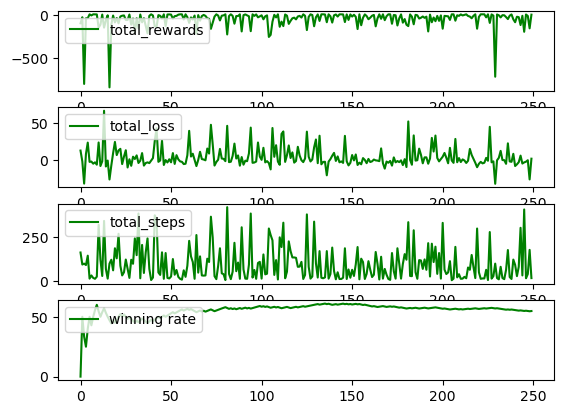

100%|█████████▉| 275/276 [00:52<00:00,  2.66it/s, Game: 276, 10X5, won, steps: 282, dfs_steps: 518, reward: -118, loss 31.5819091796875, Win: 53.62%]    

Episode: 276, Steps: 282, dfs_steps: 518, reward: -118, loss 31.5819091796875


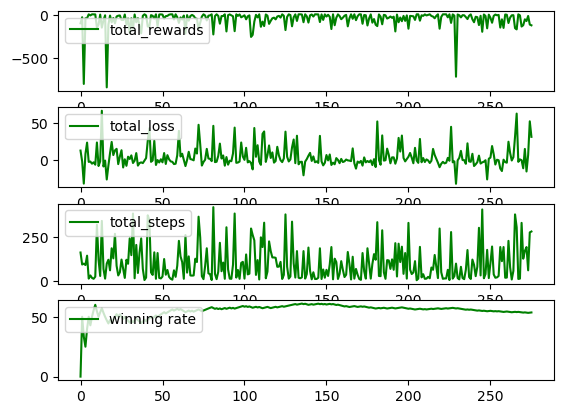

100%|██████████| 276/276 [00:53<00:00,  5.21it/s, Game: 276, 10X5, won, steps: 282, dfs_steps: 518, reward: -118, loss 31.5819091796875, Win: 53.62%]


In [183]:
EPSILON = np.finfo(np.float32).eps.item()
pg = REINFORCEAgent(env, max_color, max_length, max_empty, EPSILON, GAMMA, LR, DEVICE)
pg_train_res = pg.train(EPISODES, plot=True)

In [184]:
print_eval_num(pg_train_res["board_config_wins"])

148 276 {8: 12, 10: 24, 7: 9, 11: 20, 13: 16, 14: 10, 9: 22, 4: 0, 6: 22, 12: 11, 5: 2} {8: 36, 10: 36, 7: 25, 11: 36, 13: 26, 14: 18, 9: 33, 4: 5, 6: 24, 12: 25, 5: 12} {4: 31, 2: 55, 5: 24, 3: 31, 6: 7} {4: 73, 2: 62, 5: 58, 3: 63, 6: 20}
Win: 53.62% (276 games)
Win by number of Tubes (2 empty)
	8: 33.33% (36 games)
	10: 66.67% (36 games)
	7: 36.0% (25 games)
	11: 55.56% (36 games)
	13: 61.54% (26 games)
	14: 55.56% (18 games)
	9: 66.67% (33 games)
	4: 0.0% (5 games)
	6: 91.67% (24 games)
	12: 44.0% (25 games)
	5: 16.67% (12 games)
Win by Length
	4: 42.47% (73 games)
	2: 88.71% (62 games)
	5: 41.38% (58 games)
	3: 49.21% (63 games)
	6: 35.0% (20 games)


In [185]:
pg_val_res = pg.evaluate(Phase.VALIDATION)
print_eval_num(pg_val_res["board_config_wins"])

100%|██████████| 138/138 [00:26<00:00,  5.23it/s]

83 138 {6: 6, 10: 12, 12: 8, 9: 13, 7: 11, 5: 1, 14: 5, 13: 13, 8: 6, 11: 8, 4: 0} {6: 11, 10: 25, 12: 15, 9: 18, 7: 15, 5: 4, 14: 8, 13: 14, 8: 13, 11: 13, 4: 2} {6: 5, 5: 18, 3: 14, 4: 13, 2: 33} {6: 13, 5: 28, 3: 31, 4: 29, 2: 37}
Win: 60.14% (138 games)
Win by number of Tubes (2 empty)
	6: 54.55% (11 games)
	10: 48.0% (25 games)
	12: 53.33% (15 games)
	9: 72.22% (18 games)
	7: 73.33% (15 games)
	5: 25.0% (4 games)
	14: 62.5% (8 games)
	13: 92.86% (14 games)
	8: 46.15% (13 games)
	11: 61.54% (13 games)
	4: 0.0% (2 games)
Win by Length
	6: 38.46% (13 games)
	5: 64.29% (28 games)
	3: 45.16% (31 games)
	4: 44.83% (29 games)
	2: 89.19% (37 games)


In [68]:
# pg.save(pg_train_res["board_config_wins"], pg_val_res["board_config_wins"], f"smart reward 10, {EPISODES} episodes, MLP, no max")

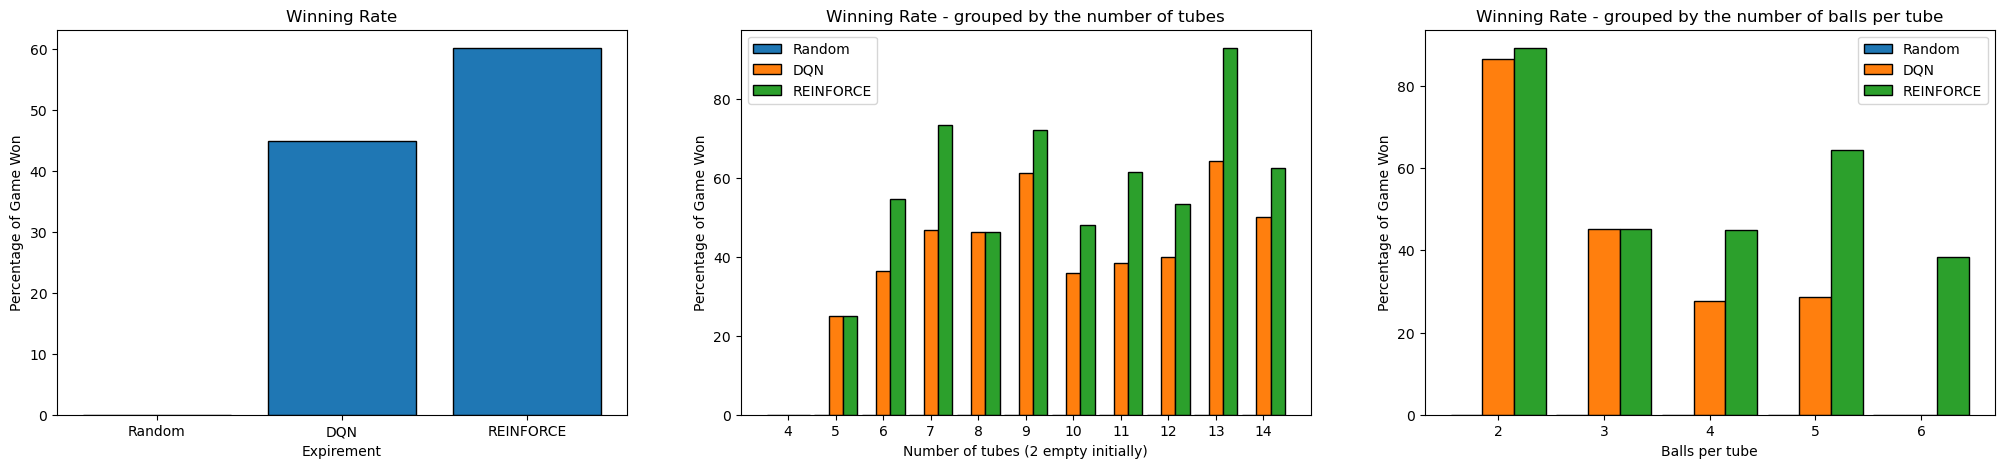

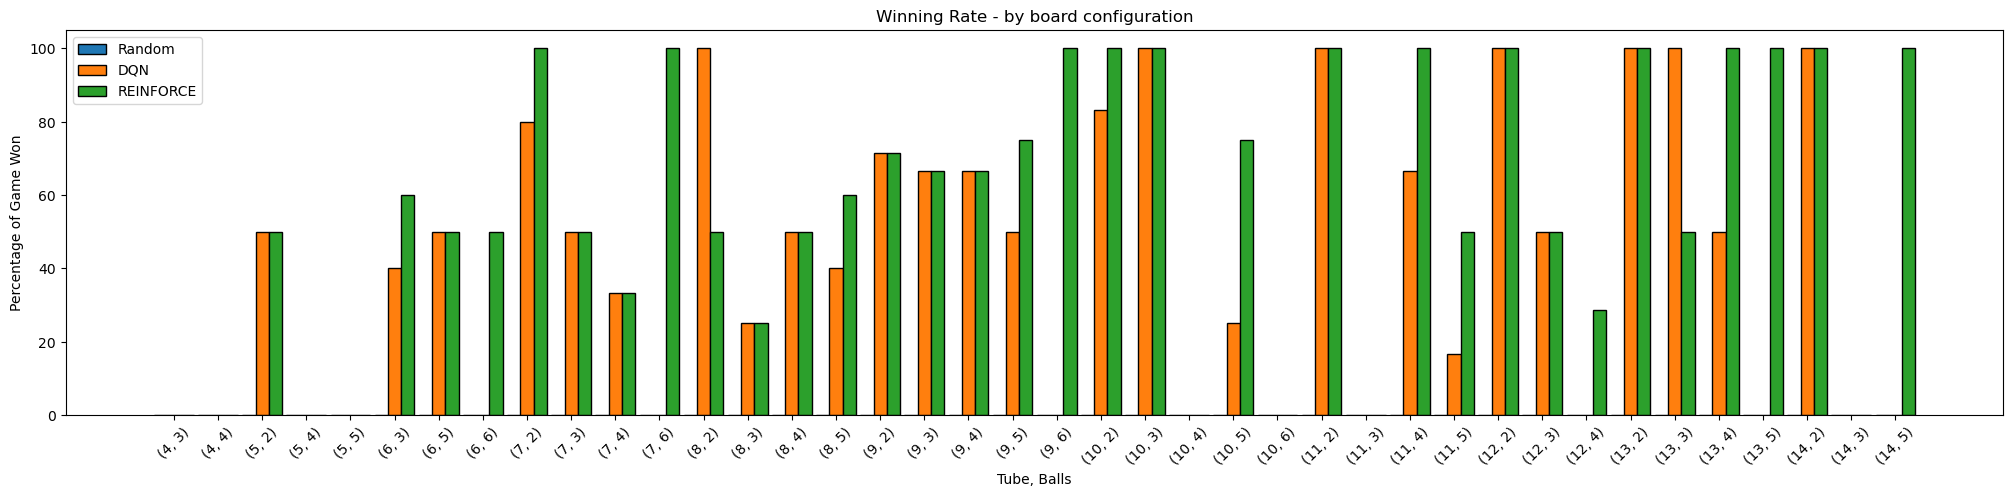

In [191]:
plot_winning({"Random": rand_val_res["board_config_wins"], "DQN": dqn_val_res["board_config_wins"], "REINFORCE": pg_val_res["board_config_wins"]})

In [ ]:
# plot_data_dist(train_data)

In [ ]:
# plot_data_dist(validate_data)

In [ ]:
# rand.eval_one(Phase.VALIDATION, i=15, render=True)

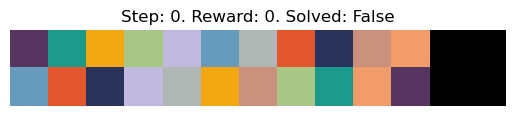

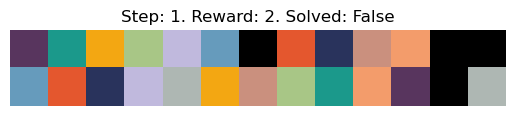

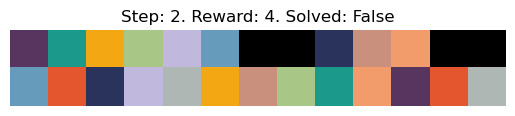

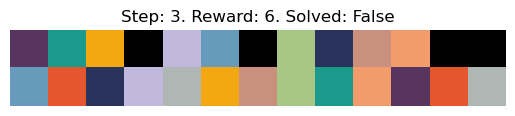

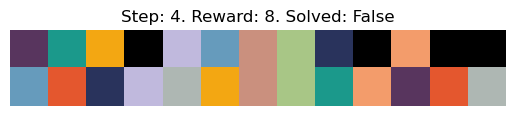

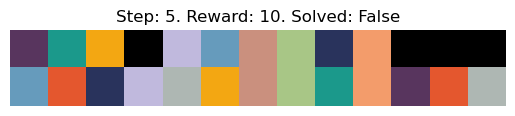

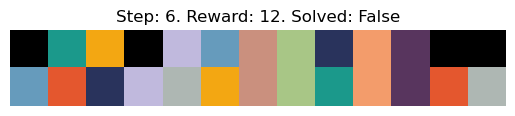

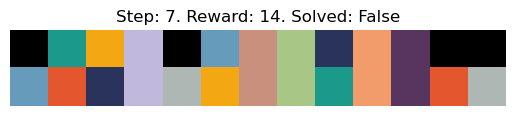

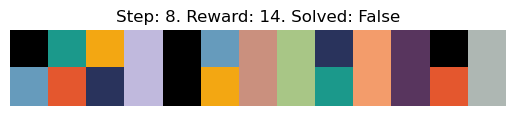

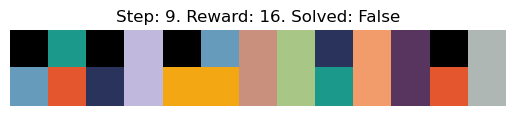

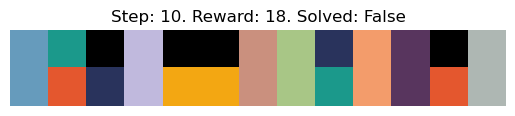

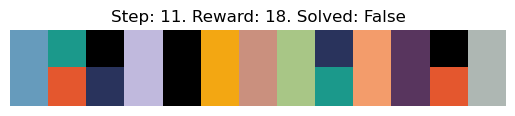

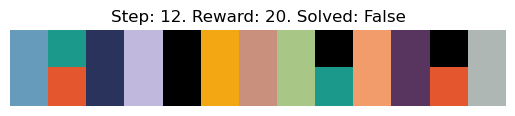

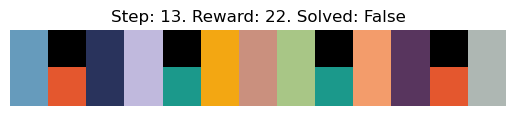

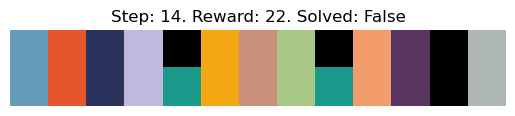

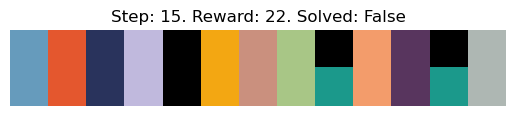

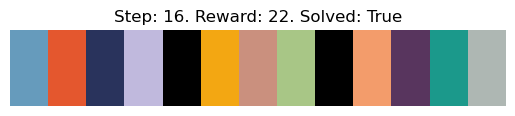

{'states': [array([[ 4,  5],
         [ 0,  1],
         [ 2,  3],
         [ 9, 10],
         [ 8,  9],
         [ 3,  4],
         [ 7,  8],
         [10,  0],
         [ 1,  2],
         [ 6,  7],
         [ 5,  6],
         [-1, -1],
         [-1, -1]], dtype=int16),
  array([[ 4,  5],
         [ 0,  1],
         [ 2,  3],
         [ 9, 10],
         [ 8,  9],
         [ 3,  4],
         [ 7, -1],
         [10,  0],
         [ 1,  2],
         [ 6,  7],
         [ 5,  6],
         [-1, -1],
         [ 8, -1]], dtype=int16),
  array([[ 4,  5],
         [ 0,  1],
         [ 2,  3],
         [ 9, 10],
         [ 8,  9],
         [ 3,  4],
         [ 7, -1],
         [10, -1],
         [ 1,  2],
         [ 6,  7],
         [ 5,  6],
         [ 0, -1],
         [ 8, -1]], dtype=int16),
  array([[ 4,  5],
         [ 0,  1],
         [ 2,  3],
         [ 9, -1],
         [ 8,  9],
         [ 3,  4],
         [ 7, -1],
         [10, 10],
         [ 1,  2],
         [ 6,  7],
         [ 5, 

In [216]:
ddqn.eval_one(Phase.VALIDATION, i=15, render=True)

In [ ]:
# pg.eval_one(Phase.VALIDATION, i=15, render=True)